# Assignment 2 Time series clustering exercise
yg833

For this week, I worked with QY(qg412), Rachel (rms818), and Khloe(kyn227).


## Data
- Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

- The data is on the github repo. Each file is the economic census for 1 year. 
Download it programmatically and move it to PUIdata

-  Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means
    in **a few** clusters (as discussed there is no real good, sound way to 
    decide what a good number is here. try a few options, keeping in mind 
    a few is more than a couple, but i recommand you stay within the 
    single digit numbers)
    
    3. plot the cluster centers (if you used K means those are the means of 
    the clusters). you can plot for example the cluster centers overlayed on 
    each time series (using the alpha channel to control the opacity in the 
    plot may be helpful here).
    
    4. Use another clustering algorithm (of your choice)
    
    5. overlay your data on a NYC map: you can use shapefiles for the 
    zip codes and different colors for different clusters
    
    6. Compare the results of the 2 algorithms
    
    7. attempt an interpretation. this is dangerous ground: clustering is 
    an exploratory tool so you do not want to jump to conclusions because 
    you see some clusters! but seeing structure in your data can inform 
    your next moves as an investigator. 
    
Note on preprocessing: the preparation of these data should include the "standardization" of the time seris. 
*Always when you apply a moachine learning model you should standardize the data or whiten it.*
These operations may be complicated preprocessing operation, they can for example invoke PCA, and they are aimed at removing covariance in the feature space.

The simplest version of whitening *standardizes each feature*" from every column (feature) you subtract the mean and you divide it by the standard deviation.

But the time series preprocessing is different if you want to use each time stamp as feature: because you want to maintain the coherence of the data, i.e. you **do not want** to treat each feature as an independent feature! the pattenrs in the time series are what you are clustering on (time series goes up and down, creating a pattern) and those patterns would be lost by whitening.

*So when you cluster or otherwise use a time series in a model, using each timestamp as a feature, you want to standardize the observations, not the features.* 

**From each row of your table (observation, in this case each zipcode) subtract the mean and you divide the row by the standard deviation.**  

In [143]:
# set up libraries
from __future__ import print_function, division

import os
import sys
import urllib
import io
import zipfile

import pylab as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn import mixture
import scipy.cluster as scp

%pylab inline
%matplotlib inline
from IPython.display import Image
from IPython.display import clear_output


Populating the interactive namespace from numpy and matplotlib


## Task 1: Get and Process the Data

# Data cleaning
you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: read the instructions below on pre-processing. Afte rthat:

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))


In [85]:
# setting environmental variable
os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
print(os.environ["PUIDATA"])

/nfshome/yg833/PUIdata


In [86]:
# list of urls
url = ['https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp00totals.zip',
       'https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp01totals.zip',
       'https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp02totals.zip',
       'https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp03totals.zip',
       'https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp04totals.zip',
       'https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp05totals.zip',
       'https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp06totals.zip',
       'https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp07totals.zip',
       'https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp08totals.zip',
       'https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp09totals.zip',
       'https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp10totals.zip',
       'https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp11totals.zip',
       'https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp12totals.zip',
       'https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp13totals.zip',
       'https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp14totals.zip',
       'https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp94totals.zip',
       'https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp95totals.zip',
       'https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp96totals.zip',
       'https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp97totals.zip',
       'https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp98totals.zip',
       'https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp99totals.zip']
       

In [87]:
census_years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
                '2009', '2010', '2011', '2012', '2013', '2014', '1994', '1995', '1996',
                '1997', '1998', '1999']

In [88]:
# retrieve csv file from the url
zip_file_names = 'annual_economic_census_data_'
zip_files = []
for i in range(len(url)):
    zip_files.append(zip_file_names + url[i][61:76])

In [89]:
if os.path.isdir(os.getenv("PUIDATA") + '/' + 'annual_economic_data') == False and \
len(os.listdir(os.getenv("PUIDATA") + '/' + 'annual_economic_data')) < 40:
    os.mkdir('annual_economic_data')
    for i in range(len(url)):
        urllib.request.urlretrieve(url[i], 'annual_economic_data/' + zip_files[i])
    !mv annual_economic_data $PUIDATA

In [90]:
for i in range(len(url)):
    temp = zipfile.ZipFile(os.getenv("PUIDATA") + '/annual_economic_data/' + zip_files[i])
    temp.extractall(os.getenv("PUIDATA") + '/' + 'annual_economic_data')
    temp.close()

In [91]:
url2 = 'https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip'
urllib.request.urlretrieve(url2, 'nyc_zipcodes_shape.zip')

('nyc_zipcodes_shape.zip', <http.client.HTTPMessage at 0x7fd564dc0da0>)

In [92]:
!mv nyc_zipcodes_shape.zip $PUIDATA

In [93]:
nyc_temp = zipfile.ZipFile(os.getenv("PUIDATA") + '/nyc_zipcodes_shape.zip')
nyc_temp.extractall(os.getenv("PUIDATA") + '/' + 'nyc_zipcodes_shape')
nyc_temp.close()

#### Read in Census Bureau Economic Data

In [94]:
dfs = [] # list of dataframes 
for i in range(len(url)):
    temp_df = pd.read_csv(os.getenv("PUIDATA") + '/annual_economic_data/' + url[i][61:72] + '.txt')
    temp_df['census_year'] = census_years[i]
    print(i, temp_df.head(1))
    dfs.append(temp_df)

0    ZIP            NAME EMPFLAG  EMP  QP1  AP  EST census_year
0  501  HOLTSVILLE, NY       A    0    0   0    1        2000
1    ZIP            NAME EMPFLAG  EMP  QP1  AP  EST census_year
0  501  HOLTSVILLE, NY       B    0    0   0    6        2001
2    ZIP            NAME EMPFLAG  EMP  QP1   AP  EST census_year
0  501  HOLTSVILLE, NY     NaN   40  148  660   11        2002
3    zip            name empflag  emp  qp1  ap  est census_year
0  501  HOLTSVILLE, NY       B    0    0   0    7        2003
4    zip            name empflag  emp  qp1   ap  est census_year
0  501  HOLTSVILLE, NY     NaN   34  170  773    8        2004
5    zip            name empflag  emp  qp1  ap  est census_year
0  501  HOLTSVILLE, NY       B    0    0   0    2        2005
6    zip            name empflag  emp  qp1   ap  est census_year
0  501  HOLTSVILLE, NY     NaN   39  216  979    8        2006
7    zip            name empflag emp_nf  emp qp1_nf  qp1 ap_nf  ap  est  \
0  501  HOLTSVILLE, NY       B      D

In [95]:
# seems like there are slight differences in the column names, so lets standardize it
for i in range(len(url)):
    if 'ZIP' in dfs[i].columns:
        dfs[i].rename(columns={'ZIP':'ZIPCODE'}, inplace=True)
    if 'zip'in dfs[i].columns:
        dfs[i].rename(columns={'zip':'ZIPCODE'}, inplace=True)
    if 'est'in dfs[i].columns:
        dfs[i].rename(columns={'est':'EST'}, inplace=True)

#### Data Fields/ Dict from Census on County Business Patterns
https://www2.census.gov/programs-surveys/cbp/technical-documentation/records-layouts/full-layout/zip_totals_layout.txt

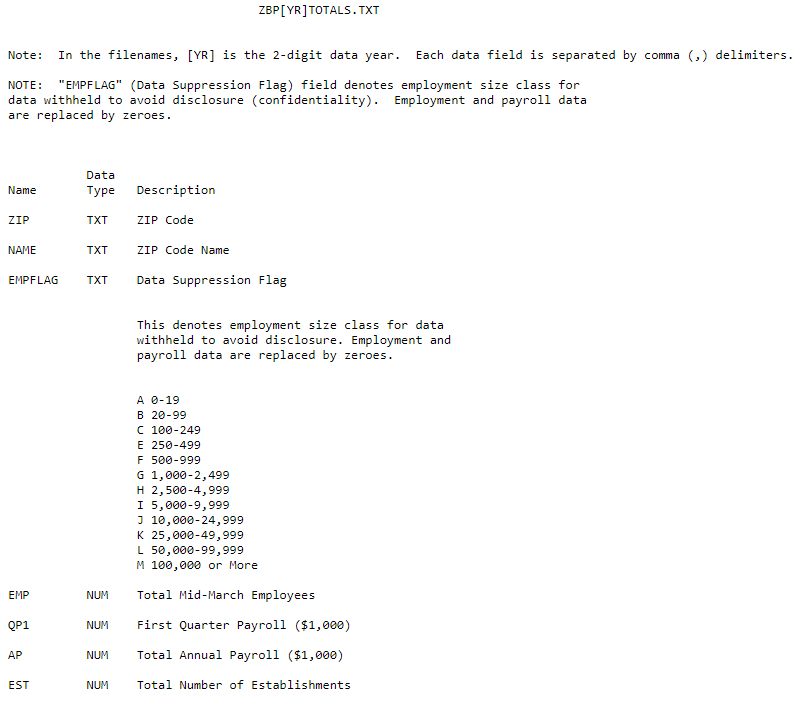

In [96]:
Image(filename = "CensusBureauCBPDict.png")

In [97]:
wdfs = [] # list of working dataframes 
for i in range(len(url)):
    wdfs.append(dfs[i][['ZIPCODE', 'EST', 'census_year']])

In [98]:
concat_wdfs = pd.concat(wdfs)

#### Read in Zip Shape File

In [99]:
nyczipsshp = gpd.read_file(os.getenv("PUIDATA") + "/nyc_zipcodes_shape/ZIP_CODE_040114.shp")
nyczipsshp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [100]:
#nyczipsshp.plot()
#nyczipsshp.drop_duplicates("ZIPCODE").plot()
#nyczipsshp
print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


In [101]:
nyc_zips = nyczipsshp['ZIPCODE'].unique()
nyc_zips

array(['11436', '11213', '11212', '11225', '11218', '11226', '11219',
       '11210', '11230', '11204', '10471', '10470', '10466', '10467',
       '10463', '10475', '10464', '10469', '10468', '10458', '10034',
       '10033', '10462', '10040', '10453', '10465', '10461', '10457',
       '10460', '10032', '10452', '10456', '10472', '10031', '10039',
       '10459', '10451', '10473', '10030', '10027', '10474', '10455',
       '10037', '10024', '10454', '10026', '10035', '10048', '10025',
       '11357', '10029', '00083', '11356', '11359', '11360', '11105',
       '10128', '10023', '11363', '10028', '11354', '11102', '11370',
       '10021', '11358', '11362', '10044', '11369', '11103', '11106',
       '11368', '11377', '11355', '11101', '11364', '10018', '10020',
       '11005', '10017', '10001', '10011', '10016', '11104', '11109',
       '10010', '11367', '10014', '10003', '11222', '10002', '11378',
       '10009', '10012', '10013', '10007', '11237', '11385', '10038',
       '11206', '100

In [102]:
type(nyc_zips[0])

str

In [103]:
filtered_wdf = concat_wdfs[concat_wdfs['ZIPCODE'].isin(nyc_zips)].reset_index()

In [104]:
filtered_wdf.dropna(inplace = True)

In [105]:
cbb_data = pd.pivot_table(filtered_wdf, values = 'EST', columns = 'census_year', index = 'ZIPCODE')

In [106]:
cbb_data.head()

census_year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
10001,6999.0,7088.0,7075.0,7154.0,7254.0,7233.0,7317.0,7188.0,7141.0,7084.0,...,7312.0,7415.0,7549.0,7472.0,7305.0,7241.0,7227.0,7235.0,7273.0,7369.0
10002,1784.0,1819.0,1919.0,2049.0,2003.0,2085.0,2277.0,2543.0,2269.0,2402.0,...,2682.0,2686.0,2685.0,2691.0,2775.0,2872.0,2912.0,2954.0,2988.0,2972.0
10003,3256.0,3377.0,3417.0,3535.0,3649.0,3659.0,3683.0,3602.0,3616.0,3704.0,...,3867.0,3909.0,4049.0,4071.0,4099.0,4113.0,4159.0,4214.0,4277.0,4333.0
10004,1115.0,1124.0,1133.0,1173.0,1176.0,1233.0,1294.0,1247.0,1253.0,1252.0,...,1260.0,1311.0,1370.0,1376.0,1379.0,1398.0,1404.0,1442.0,1479.0,1554.0
10005,1076.0,1109.0,1216.0,1227.0,1270.0,1242.0,1287.0,1249.0,1244.0,1200.0,...,1214.0,1259.0,1273.0,1291.0,1274.0,1266.0,1301.0,1273.0,1296.0,1321.0


In [107]:
#cleaning all missing values
cbb_data.shape

(245, 21)

#### standardization of values
vals.mean(axis=1) should return 0 (or something very small) everywhere

vals.mean(axis=1).shape should be (260,)

vals.std(axis=1) should return 1 everywhere

vals.std(axis=1).shape

In [108]:
vals = ((cbb_data.T - cbb_data.mean(1)) / cbb_data.std(1)).T

In [109]:
vals.head()

census_year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,0.432324,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986
10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.522100,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077
10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.127855,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833
10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,-0.313478,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945
10005,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,...,-0.496872,0.260457,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888


In [110]:
vals.dropna(inplace = True)

In [111]:
vals.head()

census_year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,0.432324,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986
10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.522100,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077
10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.127855,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833
10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,-0.313478,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945
10005,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,...,-0.496872,0.260457,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888


## Task 2: cluster the NUMBER OF ESTABLISHMENTS time series with K-means
reference notes from UInotebooks
https://github.com/fedhere/UInotebooks/blob/master/cluster/hardVSsoftClustering.ipynb

### 5 Clusters

Text(0.5, 1.0, 'Elbow curve')

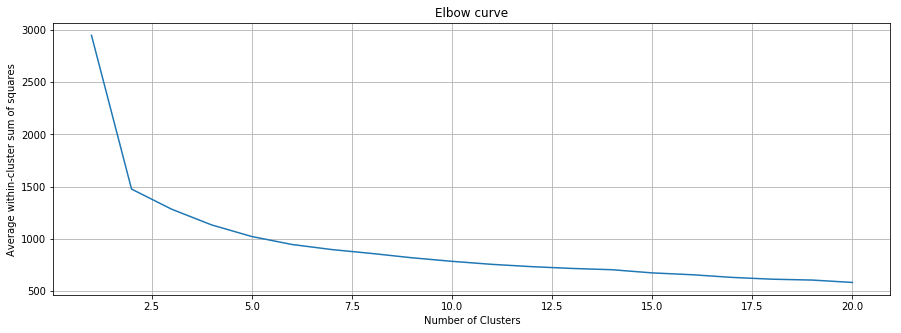

In [112]:
### adapted from https://stackoverflow.com/questions/41540751/sklearn-kmeans-equivalent-of-elbow-method

distorsions = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(vals)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
pl.plot(range(1, 21), distorsions)
pl.grid(True)
pl.xlabel('Number of Clusters')
pl.ylabel('Average within-cluster sum of squares')
pl.title('Elbow curve')

### Figure 1: Elbow Curve of K Clusters and determine the optimal number of clusters as discussed in class. Looks to be between 4 and 5.

In [113]:
#cluster with kmeans
nc = 5 # setting the number of clusters
km = KMeans(n_clusters=nc, random_state=444).fit(vals)

In [114]:
#each observation in the km object has a label: 
#that is the cluster assigned to that observation
print(km.labels_.shape, km.labels_)

(230,) [0 0 2 2 0 1 0 2 4 0 0 4 0 4 1 2 4 0 4 4 0 0 0 2 2 0 2 2 2 2 0 2 2 4 2 4 2
 0 0 4 2 0 4 4 4 3 3 1 3 1 4 0 2 4 0 3 1 1 4 0 1 4 3 3 3 3 4 4 4 2 3 1 4 2
 1 1 2 4 1 3 1 1 4 2 4 0 1 0 1 0 2 2 2 0 2 2 0 2 0 3 2 0 2 0 2 2 2 2 2 2 2
 2 0 2 2 4 2 0 2 2 2 3 3 2 0 2 2 2 0 1 2 0 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 3 2 2 0 2 2 2 0 2 2 0 2 2 4
 2 2 2 2 2 2 2 0 2 2 0 2 2 2 2 2 2 0 2 4 0 2 2 2 2 2 2 2 0 3 2 2 0 0 0 0 2
 2 2 4 2 2 2 2 0]


In [115]:
### apply the k means labels to the vals df
vals['cluster'] = km.labels_

In [116]:
km.cluster_centers_[0] # this gives you the cluster centers

array([-1.87515281, -1.56134551, -1.31713919, -0.92280085, -0.78734841,
       -0.59957887, -0.44217988, -0.44766376,  0.01524826,  0.24518878,
        0.55721582,  0.58491892,  0.65357186,  0.67185731,  0.64580097,
        0.59893487,  0.64281373,  0.71881974,  0.71459262,  0.85971017,
        1.04453623])

## Task 3: Plotting the K-means Clusters

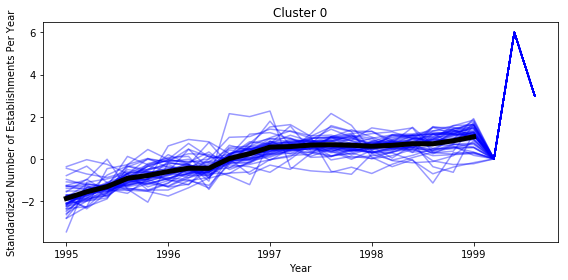

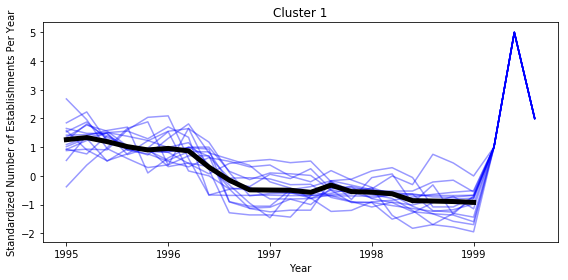

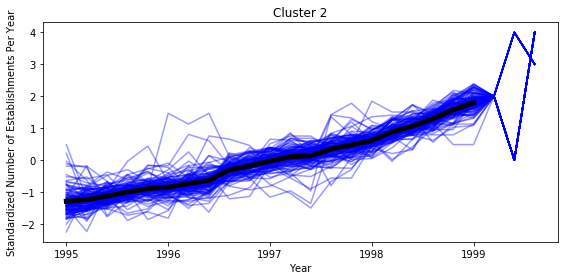

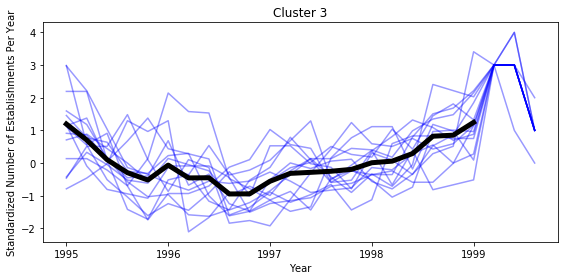

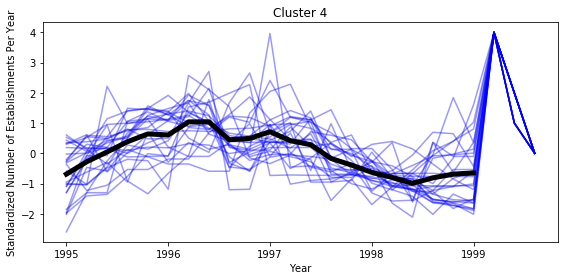

In [151]:
for i in range(nc):
    fig=pl.figure(figsize=(8,4))
    ax=fig.add_subplot(111)
    vals[vals['cluster'] == i][:-1].transpose().plot(legend = False, ax = ax, color = 'blue', alpha = 0.4)
    pl.plot(km.cluster_centers_[i], color = 'black', linewidth = 5)
    ax.set_xticklabels(range(1994, 2014), fontsize=10)
    ax.set_title('Cluster ' + str(i))
    ax.set_xlabel('Year')
    ax.set_ylabel('Standardized Number of Establishments Per Year')
    plt.tight_layout()

### Figure 2: Looking at the timeseries of zipcodes at 5 clusters. It looks like the clusters are by similarity of the timeseries. In Cluster 0, these are zips that are showing general growth since 1994 but in recent years its been more flat. In Cluster 1, these zips are showing general decline. cluster 2 shows zips with what looks like almost linear growth. In Cluster 3, there is a curve up where there was decline and now there is a bit more growth. And in Cluster 4, there is a curve down with an initial growth and now experiencing decline. 

### The map of the clusters may look something like this

In [118]:
type(nyczipsshp)

geopandas.geodataframe.GeoDataFrame

In [119]:
zips_clusters = pd.DataFrame(vals['cluster'][:-1])

In [120]:
zips_clusters.reset_index(inplace = True)

In [121]:
zips_clusters['cluster'] = zips_clusters['cluster'].astype(str) 

In [122]:
zips_clusters.dtypes

ZIPCODE     int64
cluster    object
dtype: object

In [123]:
nyczipsshp.dtypes

ZIPCODE        object
BLDGZIP        object
PO_NAME        object
POPULATION    float64
AREA          float64
STATE          object
COUNTY         object
ST_FIPS        object
CTY_FIPS       object
URL            object
SHAPE_AREA    float64
SHAPE_LEN     float64
geometry       object
dtype: object

In [124]:
nyczipsshp['zip'] = nyczipsshp['ZIPCODE'].astype(int)

In [125]:
# merge the clusters by zipcode onto nyczipsshp

merged_cbb_nyczip= nyczipsshp.merge(zips_clusters, right_on="ZIPCODE", 
                     left_on="zip")
merged_cbb_nyczip.head()

,ZIPCODE_x,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,zip,ZIPCODE_y,cluster
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",11436,11436,2
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",11213,11213,2
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",11212,11212,2
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",11225,11225,2
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",11218,11218,2


In [126]:
type(merged_cbb_nyczip)

geopandas.geodataframe.GeoDataFrame

## Task 5 Overlay ontop of NYC Map

Text(0.5, 1.0, 'Map of Zip Codes and K Clusters')

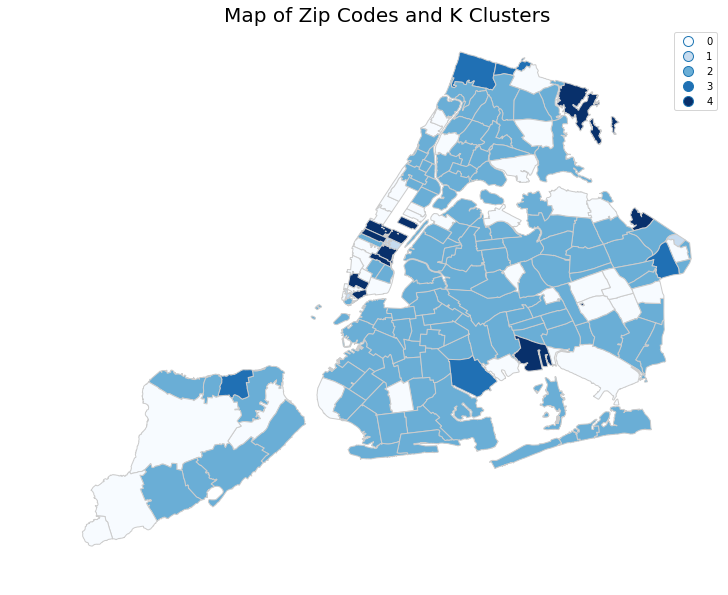

In [127]:
## plotting once using the pylab
# Setup figure and axis
f, ax = plt.subplots(1, figsize = (12,10))
# Plot layer of polygons on the axis
merged_cbb_nyczip.plot(ax = ax ,column = 'cluster', cmap='Blues', edgecolor='0.8', legend = True)
# Remove axis frames
ax.set_axis_off()
# Display
pl.title('Map of Zip Codes and K Clusters', fontdict = {'fontsize' : 20})

### Figure 3: Chloropleth of  cluster centers for 5 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.

### 7 Clusters

In [128]:
#cluster with kmeans
nc2 = 7 # setting the number of clusters
km2 = KMeans(n_clusters=nc2, random_state=444).fit(vals)

#each observation in the km object has a label: 
#that is the cluster assigned to that observation
print(km2.labels_.shape, km2.labels_)

### apply the k means labels to the vals df
vals['cluster2'] = km2.labels_

(230,) [6 6 0 0 6 5 6 0 1 6 6 1 6 1 5 0 2 6 2 2 6 6 6 0 0 6 0 0 0 0 6 0 0 1 0 2 0
 6 6 2 4 6 2 2 2 3 3 5 1 5 2 6 4 2 6 3 5 5 2 6 5 2 3 4 3 3 1 2 2 0 3 5 1 0
 5 5 0 2 5 3 5 5 1 4 1 6 5 6 5 6 0 4 0 6 0 0 6 0 6 3 0 6 4 6 0 0 0 0 0 4 0
 0 6 4 4 2 0 6 0 0 0 4 3 4 6 0 0 4 6 5 0 6 4 6 0 0 0 0 4 4 0 4 4 4 0 6 4 0
 4 0 0 0 4 0 0 0 0 4 4 0 0 4 4 4 0 6 0 0 4 4 0 3 4 4 6 0 0 0 6 0 0 6 0 0 1
 0 0 4 0 0 0 0 6 0 0 6 0 4 0 0 4 0 6 0 1 6 0 4 0 0 0 4 0 6 3 0 0 6 6 6 6 0
 0 0 1 0 4 0 0 6]


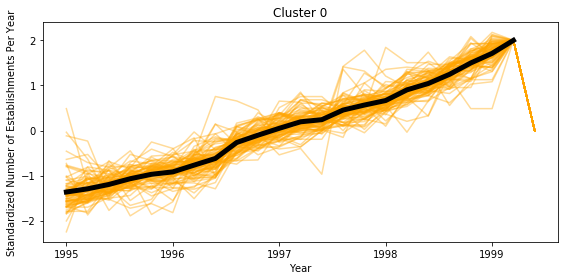

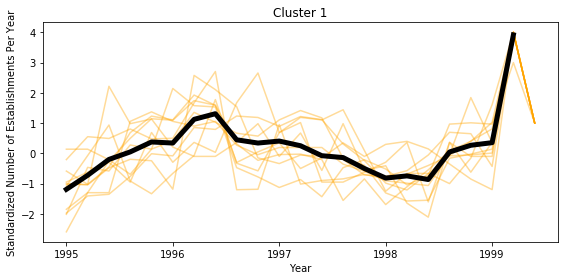

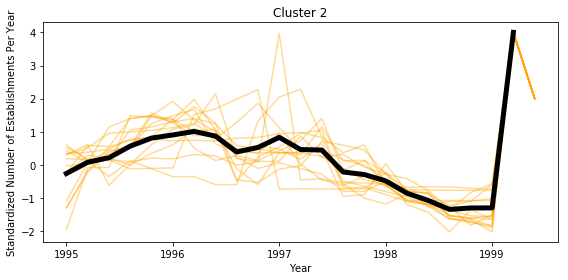

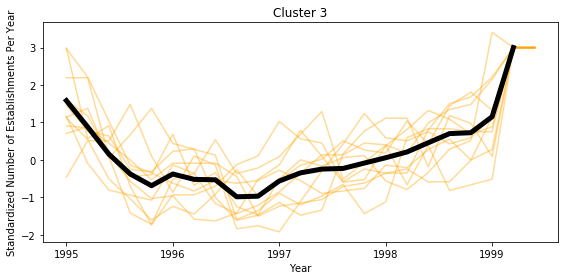

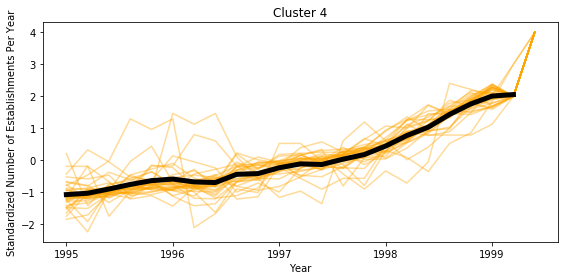

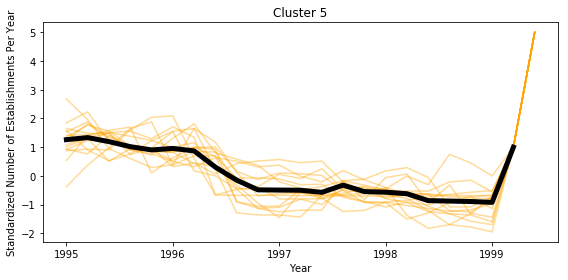

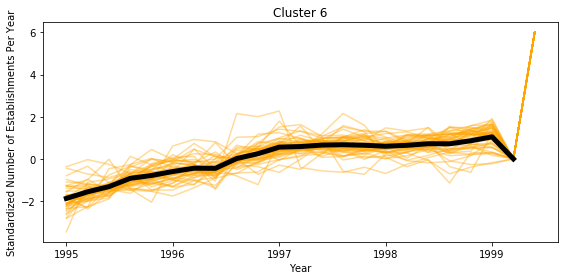

In [129]:
for i in range(nc2):
    fig=pl.figure(figsize=(8,4))
    ax=fig.add_subplot(111)
    
    vals[vals['cluster2']==i][:-1].transpose().plot(legend=False, ax=ax, color='orange', alpha=0.4)
    pl.plot(km2.cluster_centers_[i], color='black', linewidth=5)
    ax.set_xticklabels(range(1994, 2014), fontsize=10)
    ax.set_title('Cluster ' + str(i))
    ax.set_xlabel('Year')
    ax.set_ylabel('Standardized Number of Establishments Per Year')
    plt.tight_layout()

#### Figure 4: Similiar to Figure 2: Looking at the timeseries of zipcodes at 7 clusters this time. Each plot shows the similiar timeseries clustered together.

In [130]:
zips_clusters2 = pd.DataFrame(vals['cluster2'][:-1])

In [131]:
zips_clusters2.reset_index(inplace = True)

In [132]:
zips_clusters2['cluster2'] = zips_clusters2['cluster2'].astype(str) 

In [133]:
# merge the clusters by zipcode onto nyczipsshp

merged_cbb_nyczip= merged_cbb_nyczip.merge(zips_clusters2, right_on="ZIPCODE", 
                     left_on="zip")
merged_cbb_nyczip.head()

,ZIPCODE_x,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,zip,ZIPCODE_y,cluster,ZIPCODE,cluster2
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",11436,11436,2,11436,0
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",11213,11213,2,11213,0
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",11212,11212,2,11212,4
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",11225,11225,2,11225,4
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",11218,11218,2,11218,0


Text(0.5, 1.0, 'Map of Zip Codes and K Clusters')

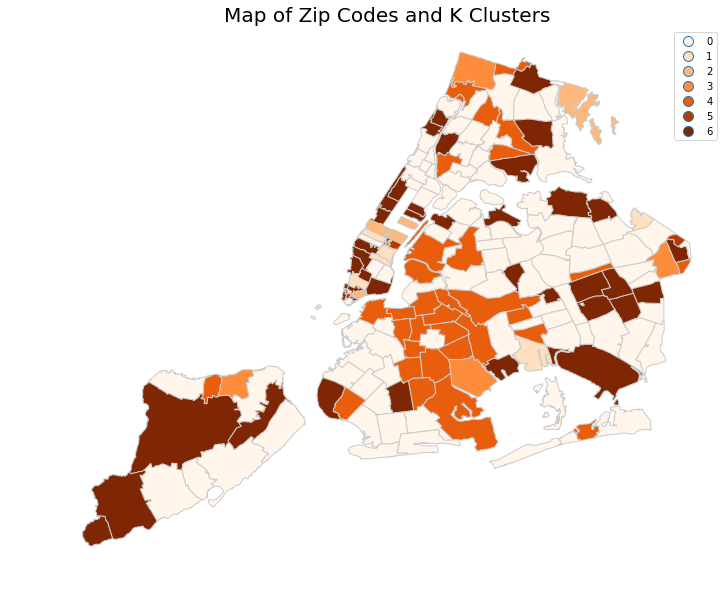

In [134]:
## plotting once using the pylab
# Setup figure and axis
f, ax = plt.subplots(1, figsize = (12,10))
# Plot layer of polygons on the axis
merged_cbb_nyczip.plot(ax = ax ,column = 'cluster2', cmap='Oranges', edgecolor='0.8', legend = True)
# Remove axis frames
ax.set_axis_off()
# Display
pl.title('Map of Zip Codes and K Clusters', fontdict = {'fontsize' : 20})

#### Figure 5: Chloropleth of NYC zipcodes by clusters. Clusters 0 and 4 in the plots above had shown more increases and cluster 6 had shown declines. So on a map we can see which areas are experiencing an increase in establishments compared to others. 

# If you want to use agglomerative clustering

In [135]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
agc = AgglomerativeClustering(n_clusters=nc, linkage='average').fit(vals)
labelsagc = agc.labels_
centroidsagc = np.zeros((nc, vals.shape[1]))

In [139]:
#cluster with agglomerative clustering
#each observation in the agc object has a label: 
#that is the cluster assigned to that observation
print(agc.labels_.shape, agc.labels_)

### apply the k means labels to the vals df
vals['cluster_agc'] = agc.labels_

(230,) [3 3 4 4 3 2 3 4 0 3 3 0 3 0 2 4 0 3 0 0 3 3 3 4 4 3 4 4 4 4 3 4 4 0 4 0 4
 3 3 0 3 3 0 0 0 1 1 2 0 2 0 3 3 0 3 1 2 2 0 3 2 0 2 1 1 1 0 0 0 4 1 2 0 4
 2 2 4 0 2 1 2 2 0 3 0 3 2 3 2 3 4 3 4 3 4 4 3 4 3 1 4 3 3 3 4 4 4 4 4 3 4
 4 3 3 3 0 4 3 4 4 4 1 1 3 3 4 4 3 3 2 4 3 3 3 4 4 4 4 3 3 4 3 3 3 4 3 3 4
 3 4 4 4 3 4 4 4 4 3 3 4 4 3 3 3 4 3 4 4 3 3 4 1 3 3 3 4 4 4 3 4 4 3 4 4 0
 4 4 3 4 4 4 4 3 4 4 3 4 3 4 4 3 4 3 4 0 3 4 3 4 4 4 3 4 3 1 4 4 3 3 3 3 4
 4 4 0 4 3 4 4 3]


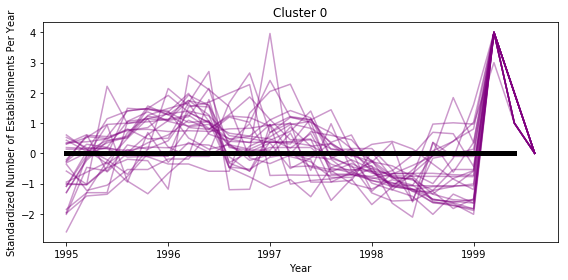

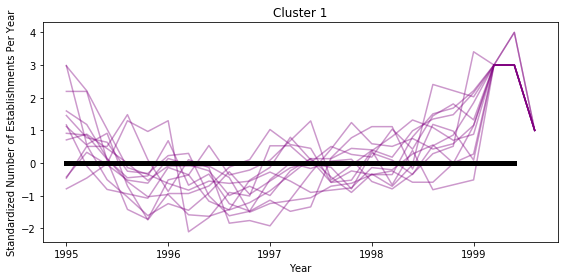

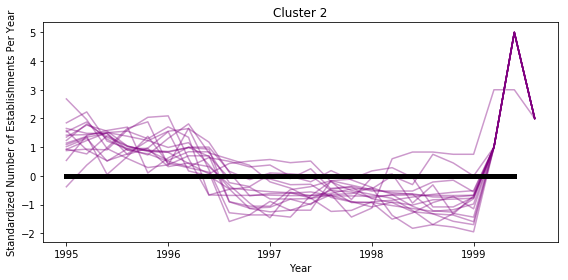

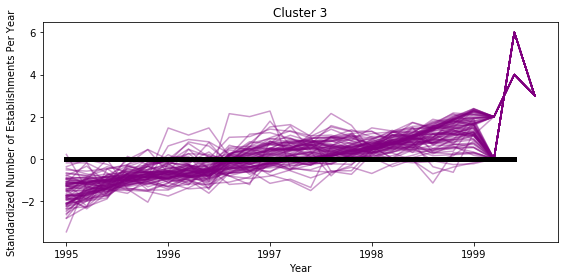

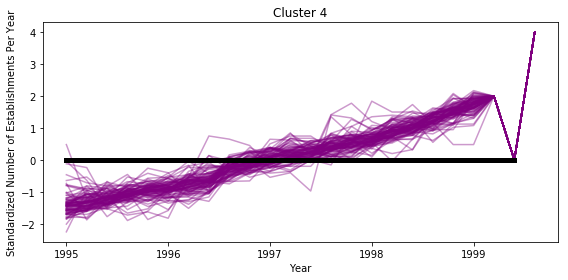

In [144]:
for i in range(nc):
    fig=pl.figure(figsize=(8,4))
    ax=fig.add_subplot(111)
    
    vals[vals['cluster_agc']==i][:-1].transpose().plot(legend=False, ax=ax, color='purple', alpha=0.4)
    pl.plot(centroidsagc[i], color='black', linewidth=5)
    ax.set_xticklabels(range(1994, 2014), fontsize=10)
    ax.set_title('Cluster ' + str(i))
    ax.set_xlabel('Year')
    ax.set_ylabel('Standardized Number of Establishments Per Year')
    plt.tight_layout()

#### Figure 6: Showing the 5 clusters using Agglomerative Clustering. The single biggest difference is that the centoids are at zero compare to the means in the KMeans version. We can also see that similiar timeseries are clustered together.

### Task 4: Cluster the NUMBER OF ESTABLISHMENTS time series using Hierarchical Clustering

Text(0.5, 1.0, 'Dendrogram of Zip Codes')

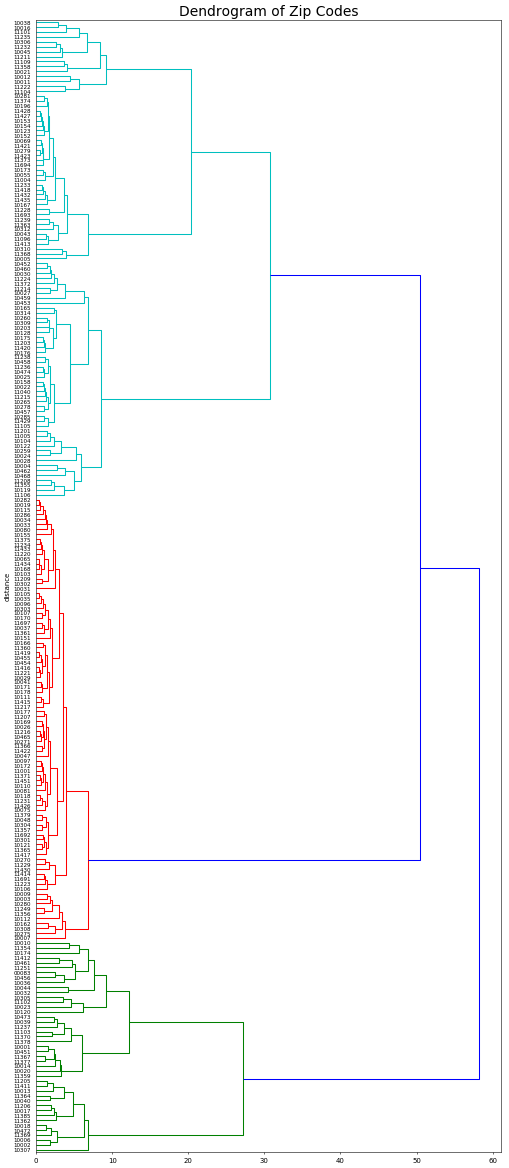

In [147]:
# https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html
fig = pl.figure(figsize=(12,30), dpi=50)
pl.ylabel("distance")
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(vals, method='ward'),
                               labels = nyc_zips, orientation='right',
                               #leaf_rotation=90,  # rotates the x axis labels
                               leaf_font_size=8.)  # font size for the x axis labels)
pl.title("Dendrogram of Zip Codes", fontsize=20)

#### Figure 6: Dendogram of the Zipcodes and the similiarities in their respective timeseries regarding establishments from 1994. When looking at a dendrogram, we are tyring to determine a cut-off. From the color coding it seems to be showing 3 clusters. And the corresponding zipcodes are shown on the Y- axis

## Task 6: Compare the results of the 2 algorithms: KMeans vs Agglomerative

Between the Agglomerative and the KMeans clusters there seems to be obvious difference in their implementation when plotted seeing that the centoids and so different than the KMean Centers. While the implementations are different, it appears that the clustering looks the same, there were 2 clusters that captured the greatest number of samples.

## Task 7: Attempt an Interpretation

Since clustering is mainly an exploratory tool. Looking the results above its hard to draw actual conclusions. Since the clusters tell me something about the similiarities of zipcodes over the last 20 years with regards to the number fo establishments, I wonder if the clustered series also reflect the similiarities in those zipcodes. Therefore when looking at the maps, we are seeing that certain areas close to each other have the same shade/ cluster. 